In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
batch='PISA'

In [4]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons.npy', 
                                   allow_pickle=True).item()

# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12noshock']
subjects = list(dict_results_across_mice.keys())

In [5]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [6]:
dict_results_across_mice.keys()

dict_keys(['BL13noshock', 'BL4demonstrator', 'BL9demonstrator', 'BL2observer', 'BL17demonstrator', 'BL22demonstrator', 'BL1noshock', 'BL20noshock', 'BL19noshock', 'BL16observer', 'BL15noshock', 'BL10observer', 'BL11noshock', 'BL6demonstrator', 'BL7noshock', 'BL14demonstrator', 'BL3demonstrator', 'BL5observer', 'BL18observer', 'BL8observer', 'BL21observer'])

In [7]:
# # remove one group
# removed = []
# for subject in dict_results_across_mice.keys():
#     if subject.split('_')[0] in ['BL'+str(i) for i in range(9,17)]:
#         removed.append(subject)
# for key in removed:
#     del dict_results_across_mice[key]

In [8]:
# dict_results_across_mice.keys()

# Format data for task PLS

In [9]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [10]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS

In [11]:
%%bash
python area_pls.py -i results_pls/PISA_n_cells.csv -o './results_pls/PISA_ncells'

In [12]:
%%bash
python area_pls.py -i results_pls/PISA_energy.csv -o './results_pls/PISA_energy'

In [13]:
%%bash
python area_pls.py -i results_pls/PISA_density.csv -o './results_pls/PISA_density'

In [14]:
%%bash
python area_pls.py -i results_pls/PISA_relative_density.csv -o './results_pls/PISA_relative_density'

# PLS ncells

In [15]:
contrasts = pd.read_csv('./results_pls/PISA_ncells_contrasts.csv')
saliences = pd.read_csv('./results_pls/PISA_ncells_saliences.csv')
contrasts = contrasts.rename(columns={"group_noshock": "noshock", 
                                      "group_demonstrator": "demonstrator", 
                                      "group_observer":"observer"})

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

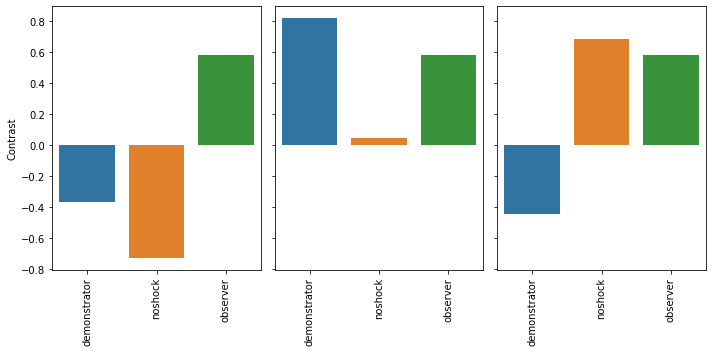

In [ ]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS energy

In [ ]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)


# PLS density

In [ ]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

In [ ]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify areas with significant area contribution

In [ ]:
batch='PISA'
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=1.96, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

In [ ]:
overlap['relative_density']

In [ ]:
[volumes[volumes['safe_name']==area]['acronym'].values[0] for area in overlap['relative_density']]

# Task PLS only on two groups: Observer e demonstrator

In [ ]:
density_obs_dem = pd.concat([data_density.groupby('group').get_group('observer'),
          data_density.groupby('group').get_group('demonstrator')])
density_obs_dem.dropna(inplace=True, axis=1)
batch = 'PISA_obs_dem'
density_obs_dem.to_csv('./results_pls/'+batch+'_density.csv')

In [ ]:
%%bash
python area_pls.py -i results_pls/PISA_obs_dem_density.csv -o './results_pls/PISA_obs_dem_density'

In [ ]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)